## **Análise de dados e Cálculo RFV para classificação de clientes da Olist.**

## O que levou ao objetivo: 
Ajudar a Olist a identificar quais são os clientes mais propensos à compra.

## Importância do cálculo RFV: 
Com o cálculo e classificação de clientes, é possível realizar programas para manter e atrair novos consumidores. 

In [0]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
# Utilizando apenas três datasets, pois são os que contêm dados importantes e necessários para o cálculo RFV. 

pedidos  = pd.read_csv('https://raw.githubusercontent.com/paolamonachesi/bootcamp-datascience-atena/master/datasets/olist_orders_dataset.csv')
itens_pedido  = pd.read_csv('https://raw.githubusercontent.com/paolamonachesi/bootcamp-datascience-atena/master/datasets/olist_order_items_dataset.csv')
clientes  = pd.read_csv('https://raw.githubusercontent.com/paolamonachesi/bootcamp-datascience-atena/master/datasets/olist_customers_dataset.csv')

In [0]:
pedidos.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [0]:
clientes.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [0]:
itens_pedido.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [0]:
# Conectando as tabelas para que podemos formar um dataframe único. 

clientes_pedidos = pd.merge(pedidos, clientes, left_on='customer_id', right_on='customer_id', how='inner')

df_olist = pd.merge(clientes_pedidos, itens_pedido, left_on='order_id', right_on='order_id', how='inner')

In [0]:
df_olist.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


# Tratando alguns dados, como identificar quais colunas são importantes para análise 


In [0]:
# Contagem de valores únicos
def count_unique(df):
  print("Quantidade de valores únicos para cada feature no conjunto de treinamento")
  for i in df.columns:
    print(f"{i}: {df[i].nunique()}")

In [0]:
count_unique(df_olist)

Quantidade de valores únicos para cada feature no conjunto de treinamento
order_id: 98666
customer_id: 98666
order_status: 7
order_purchase_timestamp: 98112
order_approved_at: 90174
order_delivered_carrier_date: 81017
order_delivered_customer_date: 95664
order_estimated_delivery_date: 450
customer_unique_id: 95420
customer_zip_code_prefix: 14976
customer_city: 4110
customer_state: 27
order_item_id: 21
product_id: 32951
seller_id: 3095
shipping_limit_date: 93318
price: 5968
freight_value: 6999


In [0]:
# Deixar apenas as colunas que serão importantes para análise e cálculo 
# customer_unique_id = valores de id único do cliente. 
# customer_id = identificação do cliente por compra. 
# order_purchase_timestamp = data da compra. 
# order_item_id = quantidade de itens do pedido. 
# price = preço de cada item. 

df_olist = df_olist[['customer_unique_id', 'customer_id', 'order_purchase_timestamp', 'order_item_id', 'price']]

In [0]:
df_olist.head()

,customer_unique_id,customer_id,order_purchase_timestamp,order_item_id,price
0,7c396fd4830fd04220f754e42b4e5bff,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,1,29.99
1,af07308b275d755c9edb36a90c618231,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,1,118.70
2,3a653a41f6f9fc3d2a113cf8398680e8,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,1,159.90
3,7c142cf63193a1473d2e66489a9ae977,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,1,45.00
4,72632f0f9dd73dfee390c9b22eb56dd6,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,1,19.90


In [0]:
df_olist.isnull().sum()

customer_unique_id          0
customer_id                 0
order_purchase_timestamp    0
order_item_id               0
price                       0
dtype: int64

# Para realizar o cálculo RFV, precisamos de três variáveis importantes. 

**R: Recência**
- Compra mais recente

**F: Frequência**
- Quantidade de compras 

**V: Valor**
- Valor da compra 


In [0]:
# Para calcular a Recência, é necessário transformar a coluna da data de compra de 'timestamp' para 'datetime'

df_olist['order_purchase_timestamp'] = pd.to_datetime(df_olist['order_purchase_timestamp'])

In [0]:
df_olist['order_purchase_timestamp'].head(3)

0   2017-10-02 10:56:33
1   2018-07-24 20:41:37
2   2018-08-08 08:38:49
Name: order_purchase_timestamp, dtype: datetime64[ns]

In [0]:
# Para calcular o Valor, é necessário multiplicar o valor dos itens pela quantidade. 

df_olist['total_pedido'] = df_olist['order_item_id'] * df_olist['price']

In [0]:
df_olist.head()

,customer_unique_id,customer_id,order_purchase_timestamp,order_item_id,price,total_pedido
0,7c396fd4830fd04220f754e42b4e5bff,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,1,29.99,29.99
1,af07308b275d755c9edb36a90c618231,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,1,118.70,118.70
2,3a653a41f6f9fc3d2a113cf8398680e8,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,1,159.90,159.90
3,7c142cf63193a1473d2e66489a9ae977,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,1,45.00,45.00
4,72632f0f9dd73dfee390c9b22eb56dd6,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,1,19.90,19.90


In [0]:
# Já que temos o total dos pedidos, podemos excluir as colunas com a quantidade de itens e preço. 

df_olist = df_olist.drop(['order_item_id', 'price'], axis=1)

In [0]:
df_olist.head()

,customer_unique_id,customer_id,order_purchase_timestamp,total_pedido
0,7c396fd4830fd04220f754e42b4e5bff,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,29.99
1,af07308b275d755c9edb36a90c618231,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,118.70
2,3a653a41f6f9fc3d2a113cf8398680e8,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,159.90
3,7c142cf63193a1473d2e66489a9ae977,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,45.00
4,72632f0f9dd73dfee390c9b22eb56dd6,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,19.90


In [0]:
# Criando variável Recência, onde é possível utilizar a função timedelta.
# Timedelta = utilizado para calcular a diferença de dias ou horas.
snapshot_date = max(df_olist.order_purchase_timestamp) + timedelta(days=1)

# Agrupando as colunas para formamos uma tabela fato (RFV)
df_olist = df_olist.groupby(['customer_unique_id']).agg({ 'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days, 'customer_id': 'nunique', 'total_pedido': 'sum'})

In [0]:
df_olist.head(2)

,order_purchase_timestamp,customer_id,total_pedido
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.9
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.9


In [0]:
# Renomeando as colunas do dataframe para facilitar entendimento 

df_olist.rename(columns = {'order_purchase_timestamp': 'Recência', 
                           'customer_id': 'Frequência', 'total_pedido': 'Valor'}, inplace=True)

In [0]:
df_olist.head(2)

,Recência,Frequência,Valor
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.9
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.9


In [0]:
df_olist['Frequência'].value_counts()

1     92507
2      2673
3       192
4        29
5         9
6         5
7         3
16        1
9         1
Name: Frequência, dtype: int64

In [0]:
df_olist.head()

,Recência,Frequência,Valor
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
0000f46a3911fa3c0805444483337064,542,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
0004aac84e0df4da2b147fca70cf8255,293,1,180.00


# Para realizar o cálculo RFV de cada cliente, iremos utilizar a função de **distribuição em quantis**. 

## Um quantil é uma medida que marca a posição de separação em um conjunto ordenado de dados amostrais de uma variável ou da sua distribuição probabilística de acordo com um percentual dado. 

In [0]:
# Recência 
# Utilizando a função qcut do pandas que permite realizar a distribuição em quantis. 
recencia_labels = range(4, 0, -1)
recencia_quartiles = pd.qcut(df_olist['Recência'], 4, labels = recencia_labels) 
df_olist = df_olist.assign(R = recencia_quartiles.values)

# Frequência 
# Utilizando a função cut que permite segmentar e classificar dados em posições 
df_olist['F'] = pd.cut(df_olist['Frequência'], [0, 1, 2, df_olist['Frequência'].max()], labels=[1, 2, 3])

# Valor 
valor_labels = range(1, 4)
valor_quartiles = pd.qcut(df_olist['Valor'], 3, labels = valor_labels)
df_olist = df_olist.assign(V = valor_quartiles.values)

In [0]:
df_olist.head()

,Recência,Frequência,Valor,R,F,V
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,4,1,2
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,4,1,1
0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,2
0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,2,1,1
0004aac84e0df4da2b147fca70cf8255,293,1,180.00,2,1,3


# Agora que cada coluna do RFV está com uma pontuação atribuída, é possível realizar a classificação dos clientes. 

# Os pesos para o cálculo serão dessa forma: 
**Recência**: tendo peso 1 para recência baixa até peso 4 para recência alta. 

**Frequência**: tendo peso 1 para frequência baixa, peso 2 para frequência média e peso 3 para frequência alta. 

**Valor**: tendo peso 1 para valor de compra baixo, peso 2 para valor de compra médio e peso 3 para valor de compra alto. 

## - Premium (com Score de 9 e 10): Recência baixa (com menor número de dias), maior frequência e maior valor.
## - Master (com Score de 6 a 8): Recência média, frequência média e valor médio. 
## - Business (com Score de 4 e 5): Recência alta(com maior número de dias), frequência baixa e valor baixo. 
## - Inativos (com Score de 3): Grupo onde tem menos compras. 


In [0]:
def classificar(df): 
  if ((df['R'] + df['F'] + df['V']) >= 9):
    return 'Premium'
  elif ((df['R'] + df['F'] + df['V']) >= 6 and (df['R'] + df['F'] + df['V']) <= 8):
    return 'Master'
  elif ((df['R'] + df['F'] + df['V']) >= 4 and (df['R'] + df['F'] + df['V']) <= 5):
    return 'Business'
  else:
    return 'Inativo'

In [0]:
df_olist['Classificação'] = df_olist.apply(classificar, axis=1)

In [0]:
df_olist.head()

,Recência,Frequência,Valor,R,F,V,Classificação
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,4,1,2,Master
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,4,1,1,Master
0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,2,Business
0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,2,1,1,Business
0004aac84e0df4da2b147fca70cf8255,293,1,180.00,2,1,3,Master


In [0]:
# Criando uma coluna apenas para o score do cliente 

def pontuacao(df): 
  if ((df['R'] + df['F'] + df['V']) == 10):
    return 10
  elif ((df['R'] + df['F'] + df['V']) == 9):
    return 9
  elif ((df['R'] + df['F'] + df['V']) == 8):
    return 8
  elif ((df['R'] + df['F'] + df['V']) == 7):
    return 7
  elif ((df['R'] + df['F'] + df['V']) == 6):
    return 6
  elif ((df['R'] + df['F'] + df['V']) == 5):
    return 5
  elif ((df['R'] + df['F'] + df['V']) == 4):
    return 4
  elif ((df['R'] + df['F'] + df['V']) == 3):
    return 3
  elif ((df['R'] + df['F'] + df['V']) == 2):
    return 2
  else:
    return 1

In [0]:
# Agrupando por categorização, com a média de cada variável e a contagem de registros.

df_olist_class = df_olist.groupby(['Classificação']).agg({ 'Recência': 'mean', 'Frequência': 'mean', 'Valor': 
                                                          ['mean','count'] }).round(1)

In [0]:
df_olist_class

Recência Frequência  Valor       
                  mean       mean   mean  count
Classificação                                  
Business         329.7        1.0  118.5  39133
Inativo          458.8        1.0   34.9   7875
Master           139.9        1.0  213.5  47767
Premium           72.9        2.3  445.2    645

In [0]:
# Para deixar o cálculo do Valor arredondado, é possível utilizar a função round:

df_olist['Valor'] = df_olist['Valor'].round(2)

In [0]:
# Extraindo as informações geradas para um arquivo CSV
df_olist.to_csv('olist.csv')

In [0]:
df_olist.head()

,Recência,Frequência,Valor,R,F,V,Classificação
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,4,1,2,Master
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,4,1,1,Master
0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,2,Business
0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,2,1,1,Business
0004aac84e0df4da2b147fca70cf8255,293,1,180.00,2,1,3,Master


Text(0, 0.5, 'RFV grid')

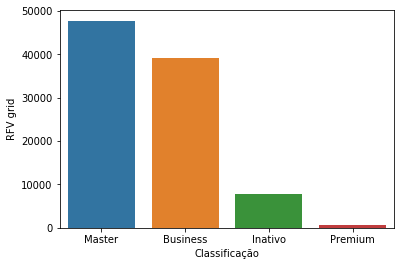

In [0]:
sns.countplot(df_olist['Classificação'])
plt.ylabel('RFV grid')

In [0]:
# verificação final - resumo estatístico dos dados de R, F, V:
df_olist.describe()

,Recência,Frequência,Valor
count,95420.000000,95420.000000,95420.000000
mean,243.600377,1.034018,161.368042
std,153.160320,0.211234,372.232087
min,1.000000,1.000000,0.850000
25%,119.000000,1.000000,48.900000
50%,224.000000,1.000000,89.990000
75%,353.000000,1.000000,167.970000
max,729.000000,16.000000,60480.000000
